In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import time
import calendar
import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import psycopg2
import sklearn
import sklearn.ensemble as ens
from sklearn import preprocessing, metrics, cluster
from scipy import stats
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

sns.set()
colours = sns.color_palette("husl", 8)
sns.set_palette(sns.color_palette(colours))
register_matplotlib_converters()

# Load Data

In [150]:
data = {}
routes = ["452", "9", "52", "267", "277", "7", "14", "35", "37", "69", "328", "6"]

b_452 = pd.read_csv("data/452 07-04-20.csv")
b_52 = pd.read_csv("data/52 07-04-20.csv")
b_7 = pd.read_csv("data/7 07-04-20.csv")
b_14 = pd.read_csv("data/14 07-04-20.csv")
b_9 = pd.read_csv("data/9 07-04-20.csv")
b_328 = pd.read_csv("data/328 07-04-20.csv")
b_69 = pd.read_csv("data/69 07-04-20.csv")
b_35 = pd.read_csv("data/35 07-04-20.csv")
b_37 = pd.read_csv("data/37 07-04-20.csv")
b_267 = pd.read_csv("data/267 07-04-20.csv")
b_277 = pd.read_csv("data/277 07-04-20.csv")
b_6 = pd.read_csv("data/6 07-04-20.csv")

data["452"] = b_452
data["52"] = b_52
data["7"] = b_7
data["9"] = b_9
data["14"] = b_14
data["328"] = b_328
data["267"] = b_267
data["277"] = b_277
data["35"] = b_35
data["37"] = b_37
data["69"] = b_69
data["6"] = b_6

# need to swap the inbound and outbound labels for data before 12/05/20 because 
# I noted them down wrong from the data collection stage
def init_explore(df, route):
    print("BUS ROUTE: ", route)
    print("Shape: ", df.shape)
    df = df.drop(columns = "arrived")
    
    df.loc[df['direction'] == 'out', 'direction'] = 'inbound'
    df.loc[df['direction'] == 'in', 'direction'] = 'outbound'
    df = df[["bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    return df

In [151]:
def add_extra_data(route):
    if route != "6":
        more = pd.read_csv("data/" + route + " 22-04-20.csv")
        more.loc[more['arrived'] == 1, 'arrived'] = True
        more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
        data[route] = data[route].append(more, ignore_index = True)
    
    more = pd.read_csv("data/" + route + " 12-05-20.csv")
    more.loc[more['arrived'] == 1, 'arrived'] = True
    more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    data[route] = data[route].append(more, ignore_index = True)

In [152]:
for route in routes:
    add_extra_data(route)

In [153]:
for route in routes:
    data[route] = init_explore(data[route], route)

BUS ROUTE:  452
Shape:  (56938, 6)
BUS ROUTE:  9
Shape:  (49935, 6)
BUS ROUTE:  52
Shape:  (92505, 6)
BUS ROUTE:  267
Shape:  (50939, 6)
BUS ROUTE:  277
Shape:  (71103, 6)
BUS ROUTE:  7
Shape:  (43271, 6)
BUS ROUTE:  14
Shape:  (80413, 6)
BUS ROUTE:  35
Shape:  (50120, 6)
BUS ROUTE:  37
Shape:  (78808, 6)
BUS ROUTE:  69
Shape:  (53844, 6)
BUS ROUTE:  328
Shape:  (41514, 6)
BUS ROUTE:  6
Shape:  (84330, 6)


In [63]:
import json

stops_in_sequence_inbound = {}
stops_in_sequence_outbound = {}

for r in routes:
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/inbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_inbound[r] = stops
        
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/outbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_outbound[r] = stops
        
print(stops_in_sequence_inbound.get("52"))

Making API call to get all stops on route  452
Making API call to get all stops on route  452
Making API call to get all stops on route  9
Making API call to get all stops on route  9
Making API call to get all stops on route  52
Making API call to get all stops on route  52
Making API call to get all stops on route  267
Making API call to get all stops on route  267
Making API call to get all stops on route  277
Making API call to get all stops on route  277
Making API call to get all stops on route  7
Making API call to get all stops on route  7
Making API call to get all stops on route  14
Making API call to get all stops on route  14
Making API call to get all stops on route  35
Making API call to get all stops on route  35
Making API call to get all stops on route  37
Making API call to get all stops on route  37
Making API call to get all stops on route  69
Making API call to get all stops on route  69
Making API call to get all stops on route  328
Making API call to get all stop

# Data Analytics

## Helper Functions

In [6]:
def convert_time_to_datetime(given_time):
    year = int(given_time[:4])
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    hour = int(given_time[11:13])
    minute = int(given_time[14:16])
    second = int(given_time[17:19])

    date_time = dt.datetime(year, month, day, hour, minute, second)
    return date_time
    
def get_time_of_day_group(given_time):
    hour = int(given_time[11:13])
    if (hour < 3) & (hour >= 0):
        return 0
    elif (hour < 6) & (hour >= 3):
        return 1
    elif (hour < 9) & (hour >= 6):
        return 2
    elif (hour < 12) & (hour >= 9):
        return 3
    elif (hour < 15) & (hour >= 12):
        return 4
    elif (hour < 18) & (hour >= 15):
        return 5
    elif (hour < 21) & (hour >= 18):
        return 6
    elif hour >= 21:
        return 7
    
colour_to_time_label = ["00-03", "03-06", "06-09", "09-12", "12-15", "15-18", "18-21", "21-00"]
cs = [colours[i] for i in range(len(colours))]

## Predict journey time by taking recent information into account 

In [276]:
def get_times_past_2_hours(stop_a, stop_b, a_id, req_time):
    
    """
    journey_times 
        - is a list of journey times for a bus arriving at stop b within the past 2 hours of the request time.
    most_recent_left
        - is the last vehicle to leave stop a and arrive at stop b before req_time
    arrived_journeys
        - is a list of bus details for vehicles arriving at stop b within the past 2 hours of the request time.
    """

    journey_times = []
    most_recent_left = -1
    arrived_journeys = []
    req_time = convert_time_to_datetime(req_time)

    for i, journey in stop_b.iterrows():
        arr_dt = convert_time_to_datetime(journey['expected_arrival'])
        past_2_hours = req_time - dt.timedelta(hours = 2)

        if (arr_dt >= past_2_hours) & (arr_dt < req_time):
            # arrived within past 2 hours and before request time
            [bus_id, stop_id, date, direction, num_trip] = journey['vehicle_id'].split('_')
            to_match_id = bus_id + '_' + a_id + '_' + date + '_' + direction + '_'
            
            for j, match in stop_a.iterrows():
                if match['vehicle_id'].startswith(to_match_id):
                    leave_dt = convert_time_to_datetime(match['expected_arrival'])
                    journey_time = arr_dt - leave_dt

                    if (journey_time > dt.timedelta(minutes = 0)) & (journey_time < dt.timedelta(minutes = 30)):
                        most_recent_left = j
                        arrived_journeys.append(journey)
                        journey_times.append(journey_time)
                        
    return most_recent_left, arrived_journeys, journey_times

In [284]:
preds_6_010520 = []
accs_6_010520 = []
req_times_6_010520 = ["2020-05-01 02:58:12", "2020-05-01 03:16:27", "2020-05-01 03:59:55", "2020-05-01 04:51:36", "2020-05-01 05:11:55","2020-05-01 05:52:43", "2020-05-01 06:07:01", "2020-05-01 06:43:22", "2020-05-01 06:59:11", "2020-05-01 07:17:02", "2020-05-01 08:00:22", "2020-05-01 08:33:18", "2020-05-01 09:10:54", "2020-05-01 09:48:37", "2020-05-01 10:02:43", "2020-05-01 10:49:21"]
req_timesx_6_010520 = []

pred_eval_arrival_times_mult("2020-05-06 16:02:01", stop_a_entries, stop_b_entries, stop_a_id, stop_b_id)

# for req_time in req_times_52_160420:
#     p, a = pred_eval_arrival_times(req_time, warwick_avn, trafalgar_sqr, warwick_avn_id, trafalgar_sqr_id)
#     if a == 0:
#         continue
#     req_timesx_6_010520.append(req_time)
#     preds_6_010520.append(p)
#     accs_6_010520.append(a)

Predicted journey time is  0
This vehicle is the one that left immediately after
Actual arrival time is 2020-04-02 13:06:36
Predicted arrival time is 2020-04-02 13:02:01


(datetime.datetime(2020, 4, 2, 13, 2, 1), '2020-04-02 13:06:36')

In [278]:
weights = {"10": 0.6, "20": 0.25, "40": 0.1, "80": 0.04, "120": 0.01}

def predict_journey_time(req_time, stop_a, stop_b, a_id):
    """
    - A request for the predicted journey time of a bus arriving at stop b is 
    made at req_time
    - Returns the predicted journey time based on journey times in the past 2 hours.
    - Journey times from the past 2 hours are weighted depending on how long ago
    they were compared to the request time.
    - most_recent_left is the the last bus that left stop a and arrived at stop be before
    req_time.

    """
    
    most_recent_left_indx, arrived, journey_times = get_times_past_2_hours(stop_a, stop_b, a_id, req_time)
    
    pred = 0
    sum_weights = 0
    for index, item in enumerate(arrived):
        eta = convert_time_to_datetime(item["expected_arrival"])
        diff = convert_time_to_datetime(req_time) - eta
        weight = 0
        if (diff <= dt.timedelta(minutes = 120)) & (diff > dt.timedelta(minutes = 80)):
            weight = weights["120"]
        elif (diff <= dt.timedelta(minutes = 80)) & (diff > dt.timedelta(minutes = 40)):
            weight = weights["80"]
        elif (diff <= dt.timedelta(minutes = 40)) & (diff > dt.timedelta(minutes = 20)):
            weight = weights["40"]
        elif (diff <= dt.timedelta(minutes = 20)) & (diff > dt.timedelta(minutes = 10)):
            weight = weights["20"]
        elif (diff <= dt.timedelta(minutes = 10)) & (diff > dt.timedelta(minutes = 0)):
            weight = weights["10"]
        journey_time = journey_times[index].total_seconds()
        pred += weight * journey_time
        sum_weights += weight
    
    if (sum_weights == 0) or (most_recent_left_indx == -1):
        return pred, most_recent_left_indx
    
    pred = pred / sum_weights
    
    return pred, most_recent_left_indx

In [283]:
def pred_arrival_time(req_time, leave_stop, pred, most_recent_left):
    """
    Finds the nearest vehicle (i.e. the one that will arrive the earliest to stop b) and 
    adds the predicted journey time onto its leave time.
    
    Params
    - req_time: the time of request
    - leave_stop: stop that is being used to find the bus to track i.e. stop_a
    - pred: predicted journey time (found previously)
    - most_recent_left: the index of the bus that left leave_stop the last but
    arrived at stop_a before the request time.
    
    Returns
    - the predicted arrival time of the bus at stop B
    - the actual vehicle that is being tracked.
    """

    for i, bus in leave_stop.iterrows():
        if i > most_recent_left:
            # Ensures that it will arrive at stop b either ON or AFTER req_time
            print("This vehicle is the one that left immediately after")
            leave_time = convert_time_to_datetime(bus['expected_arrival'])
            req_time = convert_time_to_datetime(req_time)
            if leave_time > req_time:
                print("The nearest vehicle left stop a after the request time, so this wouldn't count as historical data")
            else:
                # 30 second leeway for loading and unloading passengers
                pred_arrival = leave_time + dt.timedelta(seconds = (pred + 30))
                return pred_arrival, bus
                
    # Theoretically shouldn't get to this unless most_Recent_left is the last item in the list already
    print("There are no more buses due")    
    return 0, []

In [280]:
def get_actual(bus_to_track, pred_arr, arr_stop, arr_id):
    """
    Params:
    - bus_to_track: vehicle that is being tracked
    - pred_arr: predicted arrival time
    - arr_stop: arrival stop
    - arr_id: arrival stop ID
    
    Returns None if cannot find the matching vehicle that was being tracked.
    Otherwise, returns the tracked matching vehicle.
    """
    
    for i, item in arr_stop.iterrows():
        [bus_id, stop_id, date, direction, num_trip] = bus_to_track['vehicle_id'].split('_')
        match_id = bus_id + '_' + arr_id + '_' + date + '_' + direction + '_'
        if item['vehicle_id'].startswith(match_id):
            actual_arr_time = convert_time_to_datetime(item['expected_arrival'])
            diff = actual_arr_time - pred_arr
            if (diff >= dt.timedelta(minutes = 0)) & (diff < dt.timedelta(minutes = 10)):
                print("Actual arrival time is {}".format(item['expected_arrival']))
                print("Predicted arrival time is {}".format(pred_arr))
                return item['expected_arrival']
        
    return None

In [281]:
def pred_eval_arrival_times_mult(req_time, stop_a, stop_b, a_id, b_id):
    """
    If I request the arrival time of a bus at stop B at req_time, what is the predicted
    arrival time of the nearest bus?
    
    Returns the predicted and actual arrival time of a bus at stop B.
    If the actual bus data cannot be found, the actual arrival time = 0.
    
    """
    
    pred, most_recent_left = predict_journey_time(req_time, stop_a, stop_b, a_id)
    print("Predicted journey time is ", pred)
    
    pred_arr, bus_to_track = pred_arrival_time(req_time, stop_a, pred, most_recent_left)
    
    if pred_arr == 0:
        print("Cannot find correlating leaving bus.")
        return pred_arr, 0
    
    actual_arr = get_actual(bus_to_track, pred_arr, stop_b, b_id)
    
    if actual_arr is None:
        print("Cannot find correlating arriving bus.")
        return pred_arr, 0
    
    return pred_arr, actual_arr

### All Souls Avenue to Nottinghill Gate Station Route 52 (inbound)

If a bus left All Souls Avenue at time X, look at the other buses that have left All Souls Avenue and arrived at Nottinghill Gate Station in the past 2 hours. Weight it so that the journey times in the past 10 minutes weight more than journey times in the past 20 minutes, 20 minutes more than 40 minutes, 40 minutes more than 80 minutes and 80 minutes more than 120 minutes.

Now try to get predicted arrival time
- estimated_leaving_time = minus the predicted journey time from the request time
- Find the the bus leaving from All Souls Avenue that is leaving as close to the estimated_leaving_time as possible (after or equal to this time)
- Add the journey time back on to the leaving time and this should be the estimated arrival time.
- Then can check in the database when this vehicle actually arrived.

Length of unloading/loading time for passengers at a bus stop can be a hyperparameter to tune later on. Right now is set to 30 seconds. This can be adjusted to see varying accuracy?

Need to decide how many bus stops back I look to predict a journey time of a bus. E.g. make it standard to look back say '12' bus stops to make a prediction. Could make this a hyperparameter to see how many stations back I can go before it becomes inaccurate etc.

In [256]:
print(stops_in_sequence_inbound.get("52").index("All Souls Avenue"))
print(stops_in_sequence_inbound.get("52").index("Notting Hill Gate Station"))

5
21


In [257]:
b_52 = data["52"]

all_souls_avn = b_52.loc[(b_52['bus_stop_name'] == 'All Souls Avenue') & (b_52['direction'] == 'inbound')]
[_, all_souls_avn_id, _, _, _] = all_souls_avn.iloc[0]['vehicle_id'].split('_')
print(all_souls_avn.shape)
print(all_souls_avn_id)
all_souls_avn.head()

(1302, 5)
490003256N


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
8,All Souls Avenue,2020-04-16 02:45:23,11536_490003256N_2020-04-16_out_0,2020-04-16 02:44:32,inbound
76,All Souls Avenue,2020-04-16 03:17:18,10292_490003256N_2020-04-16_out_0,2020-04-16 03:14:10,inbound
128,All Souls Avenue,2020-04-16 03:33:51,11808_490003256N_2020-04-16_out_0,2020-04-16 03:30:17,inbound
170,All Souls Avenue,2020-04-16 03:43:50,11744_490003256N_2020-04-16_out_0,2020-04-16 03:40:58,inbound
259,All Souls Avenue,2020-04-16 04:05:45,19643_490003256N_2020-04-16_out_0,2020-04-16 04:02:24,inbound


In [258]:
ntg_stn = b_52.loc[(b_52['bus_stop_name'] == 'Notting Hill Gate Station') & (b_52['direction'] == 'inbound')]
[_, ntg_stn_id, _, _, _] = ntg_stn.iloc[0]['vehicle_id'].split('_')
print(ntg_stn.shape)
print(ntg_stn_id)
ntg_stn.head()

(1360, 5)
490000167G


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
32,Notting Hill Gate Station,2020-04-16 02:58:29,11536_490000167G_2020-04-16_out_0,2020-04-16 02:44:26,inbound
110,Notting Hill Gate Station,2020-04-16 03:29:24,10292_490000167G_2020-04-16_out_0,2020-04-16 03:14:04,inbound
159,Notting Hill Gate Station,2020-04-16 03:45:43,11808_490000167G_2020-04-16_out_0,2020-04-16 03:40:51,inbound
219,Notting Hill Gate Station,2020-04-16 03:57:20,11744_490000167G_2020-04-16_out_0,2020-04-16 03:40:51,inbound
233,Notting Hill Gate Station,2020-04-16 04:00:00,10271_490000167G_2020-04-16_out_0,2020-04-16 03:57:30,inbound


In [259]:
# Getting predicted arrival times for buses on route 52 on 16/04/20

preds_52_160420 = []
accs_52_160420 = []
req_times_52_160420 = ["2020-04-16 02:58:12", "2020-04-16 03:16:27", "2020-04-16 03:59:55", "2020-04-16 04:51:36", "2020-04-16 05:11:55","2020-04-16 05:52:43", "2020-04-16 06:07:01", "2020-04-16 06:43:22", "2020-04-16 06:59:11", "2020-04-16 07:17:02", "2020-04-16 08:00:22", "2020-04-16 08:33:18", "2020-04-16 09:10:54", "2020-04-16 09:48:37", "2020-04-16 10:02:43", "2020-04-16 10:49:21"]
req_timesx_52_160420 = []

for req_time in req_times_52_160420:
    p, a = pred_eval_arrival_times_mult(req_time, all_souls_avn, ntg_stn, all_souls_avn_id, ntg_stn_id)
    if a == 0:
        continue
        
    req_timesx_52_160420.append(req_time)
    preds_52_160420.append(p)
    accs_52_160420.append(a)

Predicted journey time is  0
The estimated leave time of a bus requested at 2020-04-16 02:58:12 is 2020-04-16 02:58:12
There is no bus due
Cannot find correlating leaving bus.
Predicted journey time is  786.0
The estimated leave time of a bus requested at 2020-04-16 03:16:27 is 2020-04-16 03:03:21
There is no bus due
Cannot find correlating leaving bus.
Predicted journey time is  775.7979797979797
The estimated leave time of a bus requested at 2020-04-16 03:59:55 is 2020-04-16 03:46:59.202020
There is no bus due
Cannot find correlating leaving bus.
Predicted journey time is  716.7142857142859
The estimated leave time of a bus requested at 2020-04-16 04:51:36 is 2020-04-16 04:39:39.285714
Actual arrival time is 2020-04-16 04:55:01
Predicted arrival time is 2020-04-16 04:56:18.714286
Predicted journey time is  731.8173913043478
The estimated leave time of a bus requested at 2020-04-16 05:11:55 is 2020-04-16 04:59:43.182609
Actual arrival time is 2020-04-16 05:22:52
Predicted arrival time

In [ ]:
# Getting predicted arrival times for buses on route 52 on 19/04/20

preds_52_190420 = []
accs_52_190420 = []
req_times_52_190420 = ["2020-04-19 08:59:59", "2020-04-19 09:13:27", "2020-04-19 09:48:55", "2020-04-19 10:15:27", "2020-04-19 10:38:41","2020-04-19 11:14:43", "2020-04-19 11:22:01", "2020-04-19 12:28:22", "2020-04-19 12:59:11", "2020-04-19 13:02:02", "2020-04-19 13:40:22", "2020-04-19 14:00:18", "2020-04-19 14:42:54", "2020-04-19 15:05:37", "2020-04-19 15:37:43", "2020-04-19 16:17:21", "2020-04-19 16:52:16", "2020-04-19 17:18:55", "2020-04-19 17:26:11", "2020-04-19 18:00:00", "2020-04-19 18:42:15", "2020-04-19 18:56:19", "2020-04-19 19:04:09", "2020-04-19 19:32:07", "2020-04-19 19:55:22", "2020-04-19 20:19:23", "2020-04-19 20:46:32", "2020-04-19 21:09:21", "2020-04-19 21:32:56", "2020-04-19 21:54:12", "2020-04-19 22:04:00"]
req_timesx_52_190420 = []
for req_time in req_times_52_190420:
    p, a = pred_eval_arrival_times_mult(req_time, all_souls_avn, ntg_stn, all_souls_avn_id, ntg_stn_id)
    if a == 0:
        continue
    
    req_timesx_52_190420.append(req_time)
    preds_52_190420.append(p)
    accs_52_190420.append(a)

In [ ]:
from sklearn.metrics import mean_squared_error

actual_52_160420 = [convert_time_to_datetime(a) for a in accs_52_160420]
times_52_160420 = [convert_time_to_datetime(t) for t in req_timesx_52_160420]

# TODO
# mse = mean_squared_error(actual_52_160420, preds_52_160420)
# print("Mean Squared Error: ", mse)

actual_52_190420 = [convert_time_to_datetime(a) for a in accs_52_190420]
times_52_190420 = [convert_time_to_datetime(t) for t in req_timesx_52_190420]

fig, ax = plt.subplots(figsize=(15,20), nrows=2, ncols=1)
ax[0].scatter(times_52_190420, actual_52_190420, label="Actual arrival time", alpha=0.5)
ax[0].scatter(times_52_190420, preds_52_190420, label="Predicted arrival time", alpha=0.5)
ax[0].set_xlabel("Time of request")
ax[0].set_ylabel("Arrival Time")
ax[0].set_ylim([dt.datetime(2020, 4, 19, 2), dt.datetime(2020, 4, 19, 22, 59, 59)])
ax[0].set_xlim([dt.datetime(2020, 4, 19, 2), dt.datetime(2020, 4, 19, 22, 59, 59)])
ax[0].set_title("Graph showing actual arrival time compared to predicted arrival time of a bus at Nottinghill Gate Station on route 52")
ax[0].legend()

ax[1].scatter(times_52_160420, actual_52_160420, label="Actual arrival time")
ax[1].scatter(times_52_160420, preds_52_160420, label="Predicted arrival time")
ax[1].set_xlabel("Time of request")
ax[1].set_ylabel("Arrival Time")
ax[1].set_ylim([dt.datetime(2020, 4, 16, 2), dt.datetime(2020, 4, 16, 22, 59, 59)])
ax[1].set_xlim([dt.datetime(2020, 4, 16, 2), dt.datetime(2020, 4, 16, 22, 59, 59)])
ax[1].set_title("Graph showing actual arrival time compared to predicted arrival time of a bus at Nottinghill Gate Station on route 52")
ax[1].legend()
plt.show()

### Different gaps for predictions for bus route 6

Experiment with different gaps to report back

Look for the leave stop}: For route X, find what stop is 15 stops before stop B. Denote this stop as stop A, which will be used to calculate the journey time of the buses. A gap of smaller and larger than 15 stops was tried, however, it was found that when using stops that were too close to each other e.g. a gap of under 5, SOMETHING WAS FOUND. It was also found that when using stops that were too far away from each other e.g. a gap of more than 25 stops, SOMETHING ELSE WAS FOUND. 

In [240]:
print("Number of stops in route 6: ", len(stops_in_sequence_outbound.get("6")))
stop_a = stops_in_sequence_outbound.get("6")[1]

# Gap = 5
stop_b_5 = stops_in_sequence_outbound.get("6")[6]

# Gap = 10
stop_b_10 = stops_in_sequence_outbound.get("6")[11]

# Gap = 15
stop_b_15 = stops_in_sequence_outbound.get("6")[16]

# Gap = 20
stop_b_20 = stops_in_sequence_outbound.get("6")[21]

# Gap = 25
stop_b_25 = stops_in_sequence_outbound.get("6")[26]

# Gap = 30
stop_b_30 = stops_in_sequence_outbound.get("6")[31]

# Gap = 35
stop_b_35 = stops_in_sequence_outbound.get("6")[36]

destination_stops = [stop_b_5, stop_b_10, stop_b_20, stop_b_25, stop_b_30, stop_b_35]
print("origin stop: ", stop_a)
print("destiation stops: ", destination_stops)

Number of stops in route 6:  38
origin stop:  Clare Road
destiation stops:  ['Whitmore Gardens', "Queen's Park Station", 'Church Street Market', 'Marble Arch Station  / Park Lane', 'Old Bond Street / Royal Academy', 'Southampton Street / Covent Garden']


In [241]:
b_6 = data["6"]

stop_a_entries = b_6.loc[(b_6['bus_stop_name'] == stop_a) & (b_6['direction'] == 'outbound')]
[_, stop_a_id, _, _, _] = stop_a_entries.iloc[0]['vehicle_id'].split('_')
print(stop_a_entries.shape)
print(stop_a_id)

stop_b_entries = b_6.loc[(b_6['bus_stop_name'] == destination_stops[0]) & (b_6['direction'] == 'outbound')]
[_, stop_b_id, _, _, _] = stop_b_entries.iloc[0]['vehicle_id'].split('_')
print(stop_b_entries.shape)
print(stop_b_id)

(862, 5)
490G00010834
(1019, 5)
490014619S


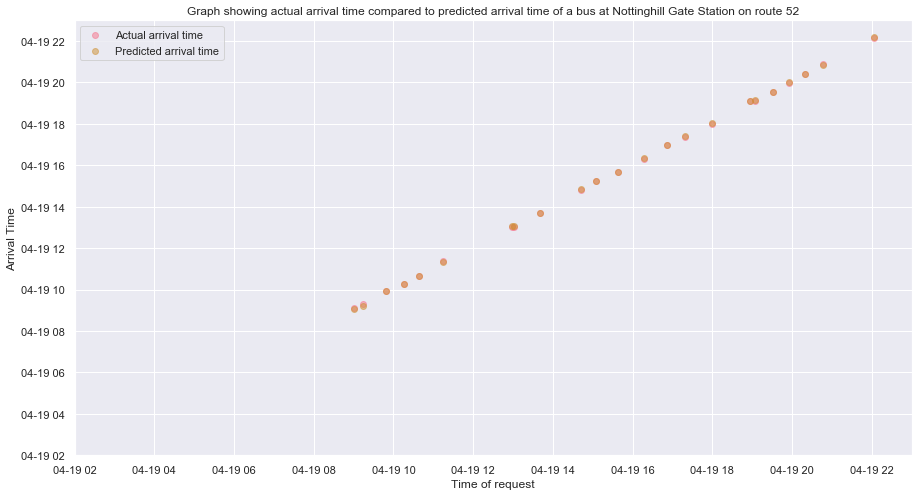

In [171]:
from sklearn.metrics import mean_squared_error

actual_6_010520 = [convert_time_to_datetime(a) for a in accs_6_010520]
times_6_010520 = [convert_time_to_datetime(t) for t in req_timesx_6_010520]

# mse = mean_squared_error(actual_52_160420, preds_52_160420)
# print("Mean Squared Error: ", mse)

actual_52_190420 = [convert_time_to_datetime(a) for a in accs_52_190420]
times_52_190420 = [convert_time_to_datetime(t) for t in req_timesx_52_190420]

fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(times_52_190420, actual_52_190420, label="Actual arrival time", alpha=0.5)
ax.scatter(times_52_190420, preds_52_190420, label="Predicted arrival time", alpha=0.5)
ax.set_xlabel("Time of request")
ax.set_ylabel("Arrival Time")
ax.set_ylim([dt.datetime(2020, 4, 19, 2), dt.datetime(2020, 4, 19, 22, 59, 59)])
ax.set_xlim([dt.datetime(2020, 4, 19, 2), dt.datetime(2020, 4, 19, 22, 59, 59)])
ax.set_title("Graph showing actual arrival time compared to predicted arrival time of a bus at Nottinghill Gate Station on route 52")
ax.legend()
plt.show()